In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry.polygon import Polygon, Point
from tqdm import tqdm
import pandas as pd
import math

import warnings
import os
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def rotate_vector(orig_vector, degree, origin=np.array([0, 0])):
    """
    Rotate a 2-D vector (point) by some given degree. Optionally around a specified origin besides (0,0).
    Supports multiple points.

    Parameters
    ----------
    orig_vector : np.array
                 Original vector(s) of size (2,) or (n,2)
    degree : float
             Counter-clockwise rotation amount in degrees
    origin : np.array
            Origin of rotation
    """
    vector = np.array(orig_vector)
    origin = np.array(origin)

    if vector.ndim == 1:
        vector = np.expand_dims(vector, axis=0)
    vector = vector - origin  # center of circle

    theta = np.radians(degree)
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )

    vector = (rotation_matrix @ vector.T).T
    vector = vector + origin
    return vector

def reock_score(geom):
    geom_area = geom.geometry.area[0]
    min_circle = geom.geometry.minimum_bounding_circle()[0]
    min_circle_area = min_circle.area
    reock_score = geom_area / min_circle_area
    return reock_score

# Arguments

In [3]:
data_path = "../data/mggg-states/"
output_dir = "../output/"
run_name = "moving_knife"
seed = 42

pop = "POP20"
d_votes = "USH20_D"
r_votes = "USH20_R"
state = "ct_2020"
n_districts = 5

# Step 0
## Initial File

<Axes: >

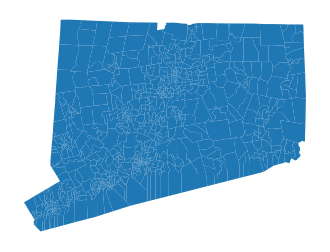

In [4]:
voting_precincts = gpd.read_file(f"../redistricting/data_prep/output/{state}/")

orig_columns = list(voting_precincts.columns)
voting_precincts[d_votes] = voting_precincts[d_votes].fillna(0)
voting_precincts[r_votes] = voting_precincts[r_votes].fillna(0)
voting_precincts[pop] = voting_precincts[pop].fillna(0)
orig_voting = voting_precincts[[d_votes, r_votes]].sum() / (
    voting_precincts[[d_votes, r_votes]].sum().sum()
)
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
voting_precincts.plot(ax=ax)


In [5]:
voting_precincts.sample(n=2)

,STATEFP20,COUNTYFP20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREOWRI,precinct_,USH20_D,USH20_R,match,POP20,geometry
594,09,001,Bridgeport 124-02,2026,474,6,4,0,BRIDGEPORT|DISTRICT 124-2-JOHN F. KENNEDY CAMPUS,1908,379,Bridgeport 124-02,7779.0,"MULTIPOLYGON (((884004.025 631949.712, 883960...."
319,09,003,Wethersfield 003-00,1434,966,26,10,0,WETHERSFIELD|DISTRICT 3-WETHERSFIELD UNITED ME...,1348,916,Wethersfield 003-00,4293.0,"POLYGON ((1020013.391 806702.921, 1020028.366 ..."


## Convert Geographies into Points (Centroid Method)

<Axes: >

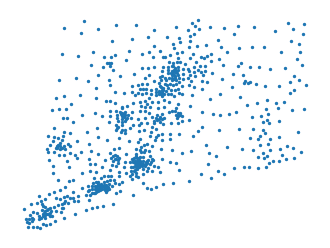

In [6]:
voting_precincts["REPRESENTATIVE_POINT"] = voting_precincts.centroid
voting_precincts["RP_LON"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
    lambda p: p.x
)
voting_precincts["RP_LAT"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
    lambda p: p.y
)
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
gpd.GeoDataFrame(data=voting_precincts[['NAME20']], geometry=[Point(r['RP_LON'],r['RP_LAT']) for i,r in voting_precincts.iterrows()], crs=voting_precincts.crs).plot(markersize=2, ax=ax)

In [7]:
voting_precincts[['NAME20','USH20_D','USH20_R','POP20','RP_LON','RP_LAT']].sample(n=2)

,NAME20,USH20_D,USH20_R,POP20,RP_LON,RP_LAT
501,Stratford 020-13,46,14,214.0,892859.309702,629119.119139
425,Stamford 007-02,2296,725,10450.0,782474.480098,582598.050709


## Set up District Column & Target Population

In [12]:
df = voting_precincts.copy().reset_index(drop=True)
df["ORIGINAL_INDEX_"] = df.index
df["DISTRICT_"] = 0  # Original

target_pop_ratio = 1 / n_districts
target_pop = target_pop_ratio * df[pop].sum()
degrees = np.array(range(0, 360, 10), dtype="f")
radians = np.radians(degrees)
radius_slopes = np.sin(radians)/np.cos(radians)
tangent_slopes = -(1 / radius_slopes)

print('Target Population:', target_pop)

Target Population: 721188.8


C:\Users\yagne\AppData\Local\Temp\ipykernel_37164\2960808910.py:10: RuntimeWarning: divide by zero encountered in divide
  tangent_slopes = -(1 / radius_slopes)


# Step 1
## Draw Minimum Bounding Circle and Calculate Center of Circle

In [9]:
# df will get smaller as algorithm loops (pieces get allocated)
df["INDEX_"] = df.index
points = df[["RP_LON", "RP_LAT"]].to_numpy()


# Create circle of remaining pieces
state_dissolved = df.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

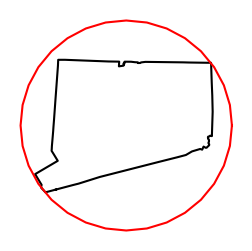

In [10]:
x_vals = np.array([c[0] for c in state_dissolved.geometry.exterior[0].coords])
y_vals = np.array([c[1] for c in state_dissolved.geometry.exterior[0].coords])
state_points = np.vstack([x_vals, y_vals]).T
plt.figure(figsize=(3,3))
plt.plot(state_points[:,0], state_points[:,1], color="black")
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
plt.axis("off")


## Rotation of State Around Minimum Bounding Circle

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

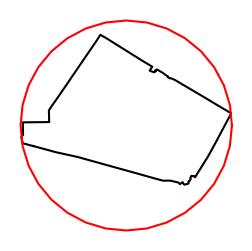

In [11]:
degree = 30
rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
plt.axis("off")

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

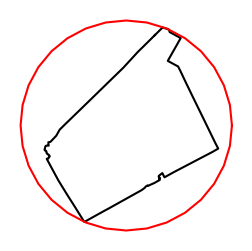

In [12]:
degree = 150
rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
plt.axis("off")

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

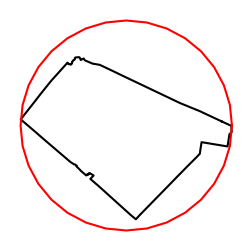

In [13]:
degree = 220
rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
plt.axis("off")

## Moving the "Slicing" Tangent Line

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

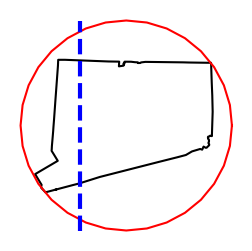

In [14]:
degree = 0
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

Reock Score 0.2383


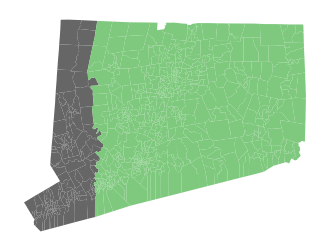

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
df_.plot(column="NEW_DISTRICT_", cmap="Accent", ax=ax)
df_a = df_.loc[df_["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
df_a_compactness = reock_score(df_a.dissolve())
print('Reock Score', round(df_a_compactness,4))

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

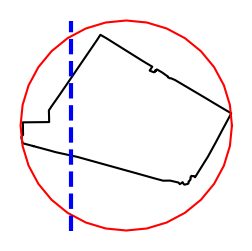

In [16]:
degree = 30
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

Reock Score 0.3166


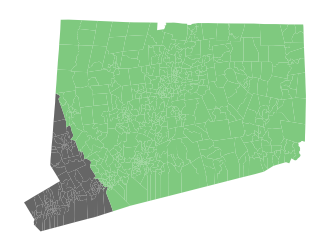

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
df_.plot(column="NEW_DISTRICT_", cmap="Accent", ax=ax)
df_a = df_.loc[df_["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
df_a_compactness = reock_score(df_a.dissolve())
print('Reock Score', round(df_a_compactness,4))

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

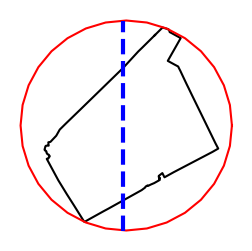

In [18]:
degree = 150
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

Reock Score 0.3855


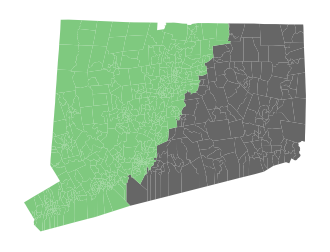

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
df_.plot(column="NEW_DISTRICT_", cmap="Accent", ax=ax)
df_a = df_.loc[df_["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
df_a_compactness = reock_score(df_a.dissolve())
print('Reock Score', round(df_a_compactness,4))

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

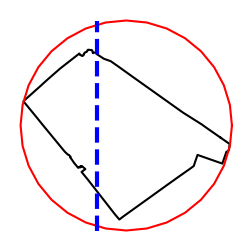

In [20]:
degree = 230
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

Reock Score 0.3766


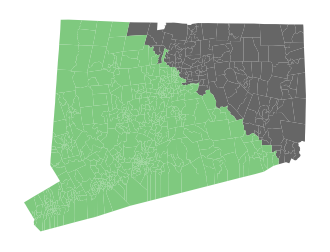

<Figure size 300x300 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
df_.plot(column="NEW_DISTRICT_", cmap="Accent", ax=ax)
plt.figure(figsize=(3,3))
df_a = df_.loc[df_["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
df_a_compactness = reock_score(df_a.dissolve())
print('Reock Score', round(df_a_compactness,4))

## Choose Best Reock

(655166.742418235, 1352423.897279271, 397115.3863844248, 1094372.5412454605)

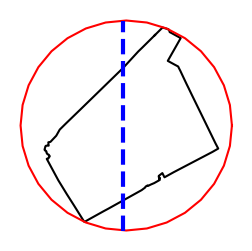

In [22]:
degree = 150
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)

df_.loc[: i- 1, "DISTRICT_"] = 1
df = df_.loc[df_['DISTRICT_'] == 0].copy()
plt.axis("off")

<Axes: >

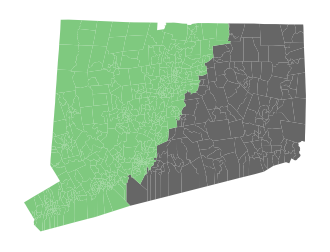

In [23]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
df_.plot(column="NEW_DISTRICT_", cmap="Accent", ax=ax)

# Step 2
## Repeat Process with the region that did not get selected in the first slice

In [24]:
# df will get smaller as algorithm loops (pieces get allocated)
df["INDEX_"] = df.index
points = df[["RP_LON", "RP_LAT"]].to_numpy()


# Create circle of remaining pieces
state_dissolved = df.dissolve()
state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
state_min_circle_o = state_min_circle.centroid
origin = np.array([state_min_circle_o.x, state_min_circle_o.y])

(647826.0593636616, 1230289.7744189422, 449321.59311077563, 1031785.3081660563)

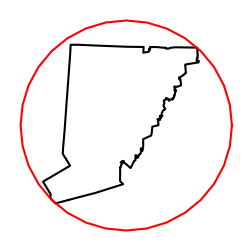

In [25]:
x_vals = np.array([c[0] for c in state_dissolved.geometry.exterior[0].coords])
y_vals = np.array([c[1] for c in state_dissolved.geometry.exterior[0].coords])
state_points = np.vstack([x_vals, y_vals]).T
plt.figure(figsize=(3,3))
plt.plot(state_points[:,0], state_points[:,1], color="black")
circumference_points = state_min_radius*np.vstack([np.cos(radians), np.sin(radians)]).T
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
plt.axis("off")

(647826.0593636616, 1230289.7744189422, 449321.59311077563, 1031785.3081660563)

<Figure size 300x300 with 0 Axes>

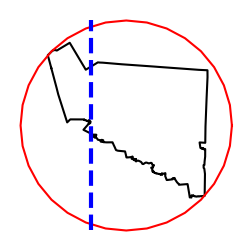

In [26]:
degree = 90
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1


plt.figure(figsize=(3,3))
rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

(647826.0593636616, 1230289.7744189422, 449321.59311077563, 1031785.3081660563)

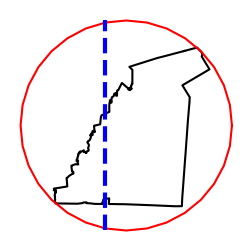

In [27]:
degree = 180
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

(647826.0593636616, 1230289.7744189422, 449321.59311077563, 1031785.3081660563)

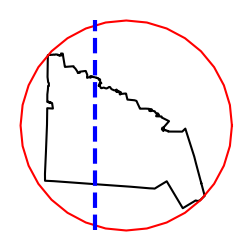

In [28]:
degree = 270
df_ = df.copy()
df_["NEW_DISTRICT_"] = 0
rotated_points = rotate_vector(points, 360 - degree, origin)
df_["ROTATED_LON"] = rotated_points[:, 0]
df_ = df_.sort_values(by="ROTATED_LON").reset_index(drop=True)
i = 0
captured_pop = 0
while captured_pop < target_pop:
    captured_pop += df_.loc[i, pop]
    i += 1
# Check for Inclusivity
pop_check1 = df_.iloc[: i - 1][pop].sum()
pop_check2 = df_.iloc[:i][pop].sum()
inclusive = (
    True
    if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
    else False
)
if inclusive:
    df_.loc[: i - 1, "NEW_DISTRICT_"] = 1
else:
    df_.loc[: i - 2, "NEW_DISTRICT_"] = 1



rotated_points = rotate_vector(state_points, 360 - degree, origin)
plt.figure(figsize=(3,3))
plt.plot(rotated_points[:,0], rotated_points[:,1], color="black")
plt.plot(state_min_circle.exterior.coords.xy[0],state_min_circle.exterior.coords.xy[1],color="red")
# plt.vlines(
#     x = np.min(state_min_circle.exterior.coords.xy[0]),
#     ymin=np.min(state_min_circle.exterior.coords.xy[1]),
#     ymax=np.max(state_min_circle.exterior.coords.xy[1]),
#     linestyle="dashed",
#     colors="darkblue",
#     linewidth=3
# )

plt.vlines(
    x = df_.iloc[i-1]['ROTATED_LON'],
    ymin=np.min(state_min_circle.exterior.coords.xy[1]),
    ymax=np.max(state_min_circle.exterior.coords.xy[1]),
    linestyle="dashed",
    colors="blue",
    linewidth=3
)
plt.axis("off")

<Axes: >

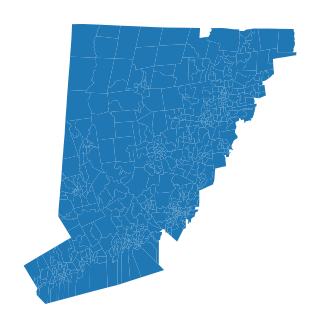

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_axis_off()
df.plot(ax=ax)

In [ ]:
state_file = "ct_2020"
final = gpd.read_file(os.path.join(output_dir, state_file,f"{state_file}_{run_name}.shp"))

In [32]:
final

,STATEFP20,COUNTYFP20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREOWRI,precinct_,USH20_D,USH20_R,match,POP20,DISTRICT_,geometry
0,09,015,Thompson 004-00,352,669,12,4,0,THOMPSON|DISTRICT 4-EAST THOMPSON FIRE STATION,376,541,Thompson 004-00,1756.0,1,"POLYGON ((1241720.272 935149.709, 1242250.449 ..."
1,09,015,Thompson 001-00,491,608,19,3,0,THOMPSON|DISTRICT 1-THOMPSON HILL FIRE STATION,506,518,Thompson 001-00,1716.0,1,"POLYGON ((1236405.343 907594.904, 1236406.093 ..."
2,09,015,Putnam 002-00,590,795,21,5,0,PUTNAM|DISTRICT 2-TOWN GARAGE,627,663,Putnam 002-00,2411.0,1,"POLYGON ((1222386.087 893335.806, 1225190.169 ..."
3,09,015,Killingly 002-02,929,1385,43,15,0,KILLINGLY|DISTRICT 2-2-KILLINGLY HIGH SCHOOL,970,1142,Killingly 002-02,4820.0,1,"POLYGON ((1238063.009 884735.737, 1238445.154 ..."
4,09,015,Thompson 002-00,897,1312,43,10,0,THOMPSON|DISTRICT 2-COMMUNITY ROOM TOWN HALL,943,1056,Thompson 002-00,4446.0,1,"POLYGON ((1218351.736 918626.508, 1219236.690 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,09,001,Greenwich 004-00,1261,710,13,2,0,GREENWICH|DISTRICT 4-NEW LEBANON SCHOOL,1253,651,Greenwich 004-00,4610.0,5,"POLYGON ((748735.434 562226.297, 748761.906 56..."
737,09,001,Stamford 001-00,1768,885,19,7,1,STAMFORD|DISTRICT 1-OUR LADY STAR OF THE SEA,1681,877,Stamford 001-00,5249.0,5,"POLYGON ((780811.919 553090.278, 781272.268 56..."
738,09,001,Greenwich 005-00,995,495,24,4,1,GREENWICH|DISTRICT 5-RIVERSIDE SCHOOL,865,645,Greenwich 005-00,2591.0,5,"POLYGON ((765122.637 547520.308, 765386.827 55..."
739,09,001,Greenwich 002-00,1316,825,30,10,1,GREENWICH|DISTRICT 2-GREENWICH TOWN HALL,1175,952,Greenwich 002-00,3692.0,5,"POLYGON ((751535.258 554441.167, 752529.483 55..."


In [33]:
import folium

In [35]:
final["PLOT"] = final["DISTRICT_"].apply(lambda x: str(x) if x <= 0 else 0)
final_ = final.dissolve("PLOT", aggfunc="first").reset_index()
final_ = final_.to_crs('EPSG:4326')
m = folium.Map(tiles = 'https://api.mapbox.com/styles/v1/yjp2007/clqlfvddw00g601quf8oud4e8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWpwMjAwNyIsImEiOiJja3I1YTZ6YTExNmJhMnVuM2J1dGFiZ3BjIn0.B_901zm_Tc_PoQ096kAZgA',
    attr = '&copy;  <a href="https://www.mapbox.com/about/maps/">Mapbox</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> <strong><a href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a></strong>',)
m.fit_bounds([(40.950943,-73.727775),(42.034577, -71.78723)])

final_.loc[final_['PLOT'].astype(int) < 1].explore(
    color = "#606060",
    m = m
)

In [36]:
final["PLOT"] = final["DISTRICT_"].apply(lambda x: str(x) if x <= 1 else 0)
final_ = final.dissolve("PLOT", aggfunc="first").reset_index()
final_ = final_.to_crs('EPSG:4326')
m = folium.Map(tiles = 'https://api.mapbox.com/styles/v1/yjp2007/clqlfvddw00g601quf8oud4e8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWpwMjAwNyIsImEiOiJja3I1YTZ6YTExNmJhMnVuM2J1dGFiZ3BjIn0.B_901zm_Tc_PoQ096kAZgA',
    attr = '&copy;  <a href="https://www.mapbox.com/about/maps/">Mapbox</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> <strong><a href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a></strong>',)
m.fit_bounds([(40.950943,-73.727775),(42.034577, -71.78723)])
final_.loc[final_['PLOT'].astype(int) == 1].explore(
    color = "#e41a1c",
    m = m
)
final_.loc[final_['PLOT'].astype(int) < 1].explore(
    color = "#606060",
    m = m
)

In [37]:
final["PLOT"] = final["DISTRICT_"].apply(lambda x: str(x) if x <= 2 else 0)
final_ = final.dissolve("PLOT", aggfunc="first").reset_index()
final_ = final_.to_crs('EPSG:4326')
m = folium.Map(tiles = 'https://api.mapbox.com/styles/v1/yjp2007/clqlfvddw00g601quf8oud4e8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWpwMjAwNyIsImEiOiJja3I1YTZ6YTExNmJhMnVuM2J1dGFiZ3BjIn0.B_901zm_Tc_PoQ096kAZgA',
    attr = '&copy;  <a href="https://www.mapbox.com/about/maps/">Mapbox</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> <strong><a href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a></strong>',)
m.fit_bounds([(40.950943,-73.727775),(42.034577, -71.78723)])
final_.loc[final_['PLOT'].astype(int) == 1].explore(
    color = "#e41a1c",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 2].explore(
    color = "#377eb8",
    m = m
)

final_.loc[final_['PLOT'].astype(int) < 1].explore(
    color = "#606060",
    m = m
)

In [38]:
final["PLOT"] = final["DISTRICT_"].apply(lambda x: str(x) if x <= 3 else 0)
final_ = final.dissolve("PLOT", aggfunc="first").reset_index()
final_ = final_.to_crs('EPSG:4326')
m = folium.Map(tiles = 'https://api.mapbox.com/styles/v1/yjp2007/clqlfvddw00g601quf8oud4e8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWpwMjAwNyIsImEiOiJja3I1YTZ6YTExNmJhMnVuM2J1dGFiZ3BjIn0.B_901zm_Tc_PoQ096kAZgA',
    attr = '&copy;  <a href="https://www.mapbox.com/about/maps/">Mapbox</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> <strong><a href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a></strong>',)
m.fit_bounds([(40.950943,-73.727775),(42.034577, -71.78723)])
final_.loc[final_['PLOT'].astype(int) == 1].explore(
    color = "#e41a1c",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 2].explore(
    color = "#377eb8",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 3].explore(
    color = "#4daf4a",
    m = m
)

final_.loc[final_['PLOT'].astype(int) < 1].explore(
    color = "#606060",
    m = m
)

In [39]:
final["PLOT"] = final["DISTRICT_"].apply(lambda x: str(x) if x <= 4 else 0)
final_ = final.dissolve("PLOT", aggfunc="first").reset_index()
final_ = final_.to_crs('EPSG:4326')
m = folium.Map(tiles = 'https://api.mapbox.com/styles/v1/yjp2007/clqlfvddw00g601quf8oud4e8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWpwMjAwNyIsImEiOiJja3I1YTZ6YTExNmJhMnVuM2J1dGFiZ3BjIn0.B_901zm_Tc_PoQ096kAZgA',
    attr = '&copy;  <a href="https://www.mapbox.com/about/maps/">Mapbox</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> <strong><a href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a></strong>',)
m.fit_bounds([(40.950943,-73.727775),(42.034577, -71.78723)])
final_.loc[final_['PLOT'].astype(int) == 1].explore(
    color = "#e41a1c",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 2].explore(
    color = "#377eb8",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 3].explore(
    color = "#4daf4a",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 4].explore(
    color = "#984ea3",
    m = m
)


final_.loc[final_['PLOT'].astype(int) < 1].explore(
    color = "#606060",
    m = m
)

In [40]:
final["PLOT"] = final["DISTRICT_"].apply(lambda x: str(x) if x <= 5 else 0)
final_ = final.dissolve("PLOT", aggfunc="first").reset_index()
final_ = final_.to_crs('EPSG:4326')
m = folium.Map(
    tiles = 'https://api.mapbox.com/styles/v1/yjp2007/clqlfvddw00g601quf8oud4e8/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoieWpwMjAwNyIsImEiOiJja3I1YTZ6YTExNmJhMnVuM2J1dGFiZ3BjIn0.B_901zm_Tc_PoQ096kAZgA',
    attr = '&copy;  <a href="https://www.mapbox.com/about/maps/">Mapbox</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> <strong><a href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a></strong>',)
m.fit_bounds([(40.950943,-73.727775),(42.034577, -71.78723)])
final_.loc[final_['PLOT'].astype(int) == 1].explore(
    color = "#e41a1c",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 2].explore(
    color = "#377eb8",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 3].explore(
    color = "#4daf4a",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 4].explore(
    color = "#984ea3",
    m = m
)

final_.loc[final_['PLOT'].astype(int) == 5].explore(
    color = "#ff7f00",
    m = m
)

